In [1]:
"""
NOTEBOOK SHOWCASING RESULTS OF ALL METHODS USED IN THE PROJECT

For more details on the implementation of each method, please look at the respective .py files:
    1) Direct regression - compare_regressors.py
    2) Taskwise regression - taskRegression.py
    3) Joint regression - fullDataRegression.py
"""
import pandas as pd
import pickle
from datetime import datetime
import numpy as np
from matplotlib import pyplot as plt
from python.project_utils import training_meta_features, hyperparameters_data
from IPython.core.display_functions import display
from python.compare_regressors import compare_regressor_with_baseline, evaluate_bayesian_regressors
from sklearn import ensemble
from python.taskRegression import evaluate_taskwise_regression
from python.fullDataRegression import evaluate_full_data_regression


#Metadata for train and test datasets
meta_train = pd.read_csv('./data/features.csv')
meta_test = pd.read_csv('./data/test_features.csv')
#Aggregated xgboost evaluation data
avg_performance = pd.read_csv('./data/average_performance.csv')

#Performance achieved on test datasets with default configuration
baseline = pd.read_csv('./data/baseline_performance.csv')

In [2]:
"""
    This cell contains the results of the Direct Regression of Hyperparameters approach from the project report
"""
""" 1.Results of different regressors without HPO"""

#Gradient boosting
gb_results_default = pd.read_csv('./data/gradient_boosting_comparison.csv')
#Random forest
rf_results_default = pd.read_csv('./data/random_forest_comparison.csv')
#Fully connected neural net - defined in FFN_regression.py
ffn_results_default = pd.read_csv('./data/neural_net.csv')
#Multilayer perceptron
mlperceptron_results_default = pd.read_csv('./data/mlperceptron_default.csv')
#KNeigbour
knn_results_default = pd.read_csv('./data/kmeans_default.csv')

""" 2.Results of different regressors with HPO using Bayesian Optimisation"""

#XGBoost regressor
xgboost_results_bayes = pd.read_csv('./data/bayes_xgboost_result.csv')
#Random forest
rf_results_bayes = pd.read_csv('./data/bayes_rforest.csv')
#KNeighbour
knn_results_bayes = pd.read_csv('./data/bayes_knn_results.csv')

In [3]:
"""
    This cell contains the results of the Indirect Regression of Hyperparameters through modeling AUC
"""

"""
    1. Taskwise regression - 94 xgboost models trained on separate training datasets. Their predictions are
    weighted based on the similarity of the training dataset whose evaluation data was used to the new dataset
"""
xgboost_results_taskwise_regression = pd.read_csv('./data/weighted_taskwise_regression_performance.csv')

"""
     2. Joint regression - a single model was trained on 15% (100.000rows) of the average performance data.
     This model takes both the metafeatures and hyperparameters as input and predicts the AUC

     A second layer of regression was added using a Guassian Process to fit the first models predictions, but the minimisation function
     can't move from a local minimum for a small number of points. For a large number of points fitting the GP to the predictions takes too long
"""
xgboost_results_joint_regression = pd.read_csv('./data/fulldata_nested_xgboost_results.csv')

In [4]:
"""
    Comparison of Baseline and all methods w.r.t AUC achieved with their recommended HPCs
"""

summary_df = baseline[['task_id','auc']]
target_columns = ['task_id','new_auc']
summary_df = pd.merge(summary_df,gb_results_default[target_columns] , on="task_id")
summary_df.rename(columns={'auc':'baseline','new_auc':'GB default'}, inplace=True)
summary_df = pd.merge(summary_df,rf_results_default[target_columns] , on="task_id")
summary_df.rename(columns={'new_auc':'RF default'}, inplace=True)
summary_df = pd.merge(summary_df,ffn_results_default[target_columns] , on="task_id")
summary_df.rename(columns={'new_auc':'FFN default'}, inplace=True)
summary_df = pd.merge(summary_df,mlperceptron_results_default[target_columns] , on="task_id")
summary_df.rename(columns={'new_auc':'MLP default'}, inplace=True)
summary_df = pd.merge(summary_df,knn_results_default[target_columns] , on="task_id")
summary_df.rename(columns={'new_auc':'KNN default'}, inplace=True)
summary_df = pd.merge(summary_df,rf_results_bayes[target_columns] , on="task_id")
summary_df.rename(columns={'new_auc':'RF with BO'}, inplace=True)
summary_df = pd.merge(summary_df,knn_results_bayes[target_columns] , on="task_id")
summary_df.rename(columns={'new_auc':'KNN with BO'}, inplace=True)
summary_df = pd.merge(summary_df,xgboost_results_bayes[target_columns] , on="task_id")
summary_df.rename(columns={'new_auc':'XGB with BO'}, inplace=True)
summary_df = pd.merge(summary_df,xgboost_results_taskwise_regression[target_columns] , on="task_id")
summary_df.rename(columns={'new_auc':'Taskwise with XGB'}, inplace=True)
summary_df = pd.merge(summary_df,xgboost_results_joint_regression[target_columns] , on="task_id")
summary_df.rename(columns={'new_auc':'Joint with XGB'}, inplace=True)
summary_df['task_id'] = summary_df['task_id'].astype(int)
summary_df = summary_df.set_index(['task_id']).transpose()
summary_df
summary_df.style.highlight_max(color = 'lightgreen', axis = 0).highlight_min(color = 'orange', axis = 0)

task_id,16,22,31,2074,2079,3493,3907,3913,9950,9952,9971,10106,14954,14970,146212,168336,167125,167119
baseline,0.997222,0.973361,0.841905,0.989416,0.915436,0.976190,0.985866,0.906926,0.996221,0.956024,0.668067,0.999297,0.910238,0.999844,0.999998,0.735831,0.962805,0.969022
GB default,0.997889,0.967194,0.807143,0.991453,0.922794,0.720238,0.908131,0.867965,0.994527,0.956815,0.698880,0.999297,0.886396,0.999983,0.999985,0.759066,0.953477,0.974388
RF default,0.998139,0.969611,0.808095,0.991936,0.929316,0.877381,0.915198,0.893939,0.993560,0.956765,0.735294,0.999297,0.918654,0.999974,0.999993,0.749506,0.954132,0.976131
FFN default,0.994778,0.972806,0.816190,0.985266,0.900401,0.814286,0.893693,0.849567,0.987380,0.910830,0.733894,0.999297,0.875175,0.999727,0.999977,0.725424,0.944110,0.925409
MLP default,0.988417,0.960611,0.800000,0.500000,0.500000,0.575000,0.500000,0.500000,0.996702,0.920371,0.733894,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
KNN default,0.997250,0.968194,0.840000,0.991432,0.910252,0.989286,0.924772,0.846320,0.996575,0.958280,0.703081,0.999297,0.918654,0.999974,0.999997,0.737038,0.971785,0.973041
RF with BO,0.997917,0.966778,0.805238,0.991691,0.928377,0.927381,0.913070,0.893939,0.993721,0.956880,0.726891,0.999297,0.913043,0.999978,0.999987,0.744692,0.959605,0.974786
KNN with BO,0.997361,0.963222,0.823810,0.992442,0.915923,0.884524,0.897644,0.883117,0.996773,0.947167,0.704482,0.999297,0.921459,0.999982,0.999994,0.753503,0.970745,0.972752
XGB with BO,0.998361,0.963056,0.827143,0.992011,0.927123,0.998810,0.988906,0.831169,0.996701,0.953686,0.679272,0.999297,0.924264,0.999956,0.999998,0.734489,0.967121,0.974193
Taskwise with XGB,0.996056,0.972333,0.832857,0.990032,0.921863,1.000000,0.923632,0.861472,0.997273,0.962610,0.742297,0.999297,0.934081,0.999879,0.999991,0.718966,0.958449,0.946038


In [5]:
"""
    Count of tasks that were matched or improved upon by each method
"""
def improvement(row, a):
    return row[row>=a].count()
baseline = summary_df.loc['baseline']
improvements = summary_df.apply(lambda x : improvement(x,baseline),axis=1)
improvements = improvements.drop(['baseline'])
print("Number of times each method was as good or better than the default config")
display(improvements)

Number of times each method was as good or better than the default config


GB default            9
RF default           10
FFN default           2
MLP default           2
KNN default          12
RF with BO           10
KNN with BO          11
XGB with BO          13
Taskwise with XGB     9
Joint with XGB        7
dtype: int64

In [6]:
"""
    Checking if there are any differences in metafeatures on tasks 22,31,3913 compared to the others - No clear differences
"""
print("Summary of metafeatures of training tasks")
meta_train[training_meta_features].describe()

Summary of metafeatures of training tasks


,MajorityClassSize,MaxNominalAttDistinctValues,MinorityClassSize,NumberOfClasses,NumberOfFeatures,NumberOfInstances,NumberOfInstancesWithMissingValues,NumberOfMissingValues,NumberOfNumericFeatures,NumberOfSymbolicFeatures
count,94.000000,92.000000,94.000000,94.000000,94.000000,94.000000,94.000000,9.400000e+01,94.000000,94.000000
mean,7694.946809,267.467391,2947.297872,7.808511,488.819149,16001.329787,733.797872,8.578104e+04,478.627660,10.191489
std,15914.193136,1779.671006,8029.261365,15.722921,1599.802393,27931.084418,5223.495247,8.275872e+05,1601.857732,25.847059
min,16.000000,2.000000,5.000000,2.000000,5.000000,100.000000,0.000000,0.000000e+00,0.000000,1.000000
25%,399.250000,2.000000,178.000000,2.000000,17.000000,1252.000000,0.000000,0.000000e+00,7.000000,1.000000
50%,1634.000000,5.000000,458.500000,2.000000,37.500000,3473.500000,0.000000,0.000000e+00,27.000000,1.000000
75%,4271.750000,10.000000,1678.500000,7.750000,120.500000,10965.250000,0.000000,0.000000e+00,86.000000,5.750000
max,93565.000000,15415.000000,47662.000000,100.000000,10001.000000,130064.000000,50000.000000,8.024152e+06,10000.000000,181.000000


In [7]:
not_improved = [22,31,3913]
meta_not_improved = meta_test[meta_test['task_id'].isin(not_improved)][training_meta_features]
meta_improved = meta_test[~meta_test['task_id'].isin(not_improved)][training_meta_features]
print("Summary of metafeatures for tasks that were not improved")
meta_not_improved.describe()

Summary of metafeatures for tasks that were not improved


,MajorityClassSize,MaxNominalAttDistinctValues,MinorityClassSize,NumberOfClasses,NumberOfFeatures,NumberOfInstances,NumberOfInstancesWithMissingValues,NumberOfMissingValues,NumberOfNumericFeatures,NumberOfSymbolicFeatures
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.0,3.0,3.000000,3.000000
mean,438.333333,7.333333,202.333333,4.666667,30.333333,1174.000000,0.0,0.0,25.000000,5.333333
std,250.815337,4.618802,96.521155,4.618802,15.307950,754.206868,0.0,0.0,20.297783,7.505553
min,200.000000,2.000000,107.000000,2.000000,21.000000,522.000000,0.0,0.0,7.000000,1.000000
25%,307.500000,6.000000,153.500000,2.000000,21.500000,761.000000,0.0,0.0,14.000000,1.000000
50%,415.000000,10.000000,200.000000,2.000000,22.000000,1000.000000,0.0,0.0,21.000000,1.000000
75%,557.500000,10.000000,250.000000,6.000000,35.000000,1500.000000,0.0,0.0,34.000000,7.500000
max,700.000000,10.000000,300.000000,10.000000,48.000000,2000.000000,0.0,0.0,47.000000,14.000000


In [8]:
print("Summary of metafeatures for tasks that were improved")
meta_improved.describe()


Summary of metafeatures for tasks that were improved


,MajorityClassSize,MaxNominalAttDistinctValues,MinorityClassSize,NumberOfClasses,NumberOfFeatures,NumberOfInstances,NumberOfInstancesWithMissingValues,NumberOfMissingValues,NumberOfNumericFeatures,NumberOfSymbolicFeatures
count,15.000000,14.000000,15.00000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,11198.666667,11.714286,1227.00000,4.866667,248.533333,15330.066667,4671.133333,10047.866667,140.466667,108.066667
std,19170.843184,18.635898,2420.89287,4.867775,501.705216,23390.641338,17992.320933,38515.892618,350.249068,400.615859
min,60.000000,2.000000,10.00000,2.000000,6.000000,540.000000,0.000000,0.000000,0.000000,1.000000
25%,353.500000,2.000000,86.50000,2.000000,10.500000,668.500000,0.000000,0.000000,7.500000,1.000000
50%,1944.000000,5.000000,206.00000,2.000000,33.000000,5404.000000,0.000000,0.000000,14.000000,1.000000
75%,11807.500000,9.250000,1015.50000,6.000000,52.500000,12269.500000,0.000000,0.000000,37.000000,6.500000
max,64007.000000,71.000000,8976.00000,20.000000,1559.000000,72983.000000,69709.000000,149271.000000,1300.000000,1556.000000


In [9]:
"""
    Loading results of Joint data regression - This will take around a minute
"""
def bayes_callback(res):
    print("Next iteration, Time:", datetime.now().strftime("%H:%M:%S"))
with open('full_data_xgboost_search.pkl', 'rb') as f:
    joint_regression_searches = pickle.load(f)
with open('full_data_xgboost_result.pkl', 'rb') as f:
    scores = pickle.load(f)
joint_regression_searches
#Getting the regression model that had the best CV score on nested sampling
best_regressor = joint_regression_searches[np.argmax(scores)].best_estimator_
best_search_results = joint_regression_searches[np.argmax(scores)].cv_results_
"""
    Here we can see the importance of different dataset metafeatures as well as XGBoost hyperparameters
    for determining the AUC. We use the regressor from the Joint regression approach that had the best
    score in nested sampling.
"""
train_features = training_meta_features + hyperparameters_data
feature_importance = pd.DataFrame({'feature': train_features, 'importance': list(best_regressor.feature_importances_)}, columns=['feature', 'importance'])
feature_importance['type'] = len(training_meta_features)*['meta'] + len(hyperparameters_data)*['hyper_parameter']
feature_importance.sort_values(by=['importance'],ascending=False)

,feature,importance,type
14,alpha,0.171885,hyper_parameter
5,NumberOfInstances,0.157089,meta
17,min_child_weight,0.088594,hyper_parameter
2,MinorityClassSize,0.066281,meta
1,MaxNominalAttDistinctValues,0.064346,meta
6,NumberOfInstancesWithMissingValues,0.055369,meta
4,NumberOfFeatures,0.051803,meta
8,NumberOfNumericFeatures,0.050696,meta
15,subsample,0.042902,hyper_parameter
3,NumberOfClasses,0.040909,meta


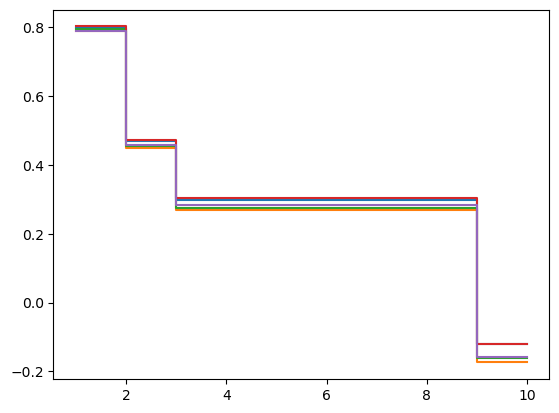

In [10]:
"""
    This is an example of how to use BayesSearchCV cv_results_
    For each of the inner folds (5 in total) we have the cost metric
"""
splits  = []
splits.append(best_search_results['split0_test_score'])
splits.append(best_search_results['split1_test_score'])
splits.append(best_search_results['split2_test_score'])
splits.append(best_search_results['split3_test_score'])
splits.append(best_search_results['split4_test_score'])

"""
    Example - plotting scores for each split - Unclear why some of the BayesSearchCV scores are negative since it should be using RMSE from XGBRegressor
"""
for split in splits:
    best_in_split = [split[0]]
    for score in split[1:]:
        best_in_split.append(min(score,best_in_split[len(best_in_split)-1]))
    plt.step(range(1,len(split)+1),best_in_split)

In [11]:
"""
    The following cells give examples of how to run different methods from the Project Report
"""

'\n    The following cells give examples of how to run different methods from the Project Report\n'

In [12]:
"""
    1.Direct regression with single regressor for all 10 hyperparameters - no HPO
    This should take 5-10min.
"""
print("Fitting Random forest regressor \n")
random_forest_results = compare_regressor_with_baseline(regressor=ensemble.RandomForestRegressor())
display(random_forest_results)

Fitting Random forest regressor 

Evaluating task with id:  16


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.9984166666666667
Evaluating task with id:  22


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.9695277777777778
Evaluating task with id:  31


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.8261904761904761
Evaluating task with id:  2074


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.9920507347036649
Evaluating task with id:  2079


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.9174908364824852
Evaluating task with id:  3493


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.838095238095238
Evaluating task with id:  3907


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.9120820668693008
Evaluating task with id:  3913


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.8852813852813852
Evaluating task with id:  9950


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.996148434898435
Evaluating task with id:  9952


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.9575718660476144
Evaluating task with id:  9971


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.7030812324929971
Evaluating task with id:  10106


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.99929676511955
Evaluating task with id:  14954


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.9102384291725105
Evaluating task with id:  14970


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.9999795198830181
Evaluating task with id:  146212


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.9999823101260665
Evaluating task with id:  167119


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.9749303479773376
Evaluating task with id:  167125


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.9534767190872648
Evaluating task with id:  168336


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.7468884490139174


,task_id,base_auc,base_time,new_auc,new_time,delta_auc,better_auc,better_time
0,16,0.997222,31.225133,0.998417,10.395434,1.194444e-03,True,True
1,22,0.973361,25.774230,0.969528,9.640014,-3.833333e-03,False,True
2,31,0.841905,1.274992,0.826190,0.426011,-1.571429e-02,False,True
3,2074,0.989416,18.240999,0.992051,17.952959,2.634807e-03,True,True
4,2079,0.915436,3.369999,0.917491,5.100997,2.054996e-03,True,False
5,3493,0.976190,0.539915,0.838095,0.224997,-1.380952e-01,False,True
6,3907,0.985866,2.770957,0.912082,1.841963,-7.378419e-02,False,True
7,3913,0.906926,0.559001,0.885281,0.394960,-2.164502e-02,False,True
8,9950,0.996221,32.786961,0.996148,30.764871,-7.217320e-05,False,True
9,9952,0.956024,2.991995,0.957572,1.981998,1.547631e-03,True,True


In [13]:
"""
    2.Direct regression with a separate model for eahc parametr. Each model is optimised using Bayesian Optimisation
    This should take 5-10min.

    Note: If you want the model to be retrained from scratch you have to:
        1) Remove bayes_rforest.pkl
    Also, the number of BO iterations was lowered from 50 to 10 in order to speedup the function,
    if you want to get the same results as seen in the table above change it n_iter to 50.
    In that case the following function call will take around 1 hour.

"""
#Results of this run will be saved at 'bayes_rforest.pkl and bayes_rforest.csv'
ADDRESS_TO_SAVE = 'bayes_rforest'
search_space = dict()
search_space['n_estimators'] = (50, 500)
search_space['max_features'] = ['auto', 'sqrt']
search_space['max_depth'] = (5, 25)
search_space['min_samples_split'] = [2, 5, 10]
search_space['min_samples_leaf'] = [1, 2, 4]
search_space['bootstrap'] = ['True', 'False']

bayes_forest_result = evaluate_bayesian_regressors(estimator=ensemble.RandomForestRegressor(),
                                                   search_space=search_space,
                                                   address_to_save=ADDRESS_TO_SAVE, n_iter=10)
display(bayes_forest_result)

Starting bayesian optimisation of regressors 
 Time = 16:38:21
{'num_round': {'best score': -0.8793371215508963, 'best config': OrderedDict([('bootstrap', 'True'), ('max_depth', 21), ('max_features', 'sqrt'), ('min_samples_leaf', 4), ('min_samples_split', 10), ('n_estimators', 329)])}, 'eta': {'best score': -0.5838586920218367, 'best config': OrderedDict([('bootstrap', 'False'), ('max_depth', 8), ('max_features', 'sqrt'), ('min_samples_leaf', 4), ('min_samples_split', 10), ('n_estimators', 52)])}, 'gamma': {'best score': -131.41977413809772, 'best config': OrderedDict([('bootstrap', 'False'), ('max_depth', 23), ('max_features', 'sqrt'), ('min_samples_leaf', 2), ('min_samples_split', 5), ('n_estimators', 381)])}, 'lambda': {'best score': -37.244871905779156, 'best config': OrderedDict([('bootstrap', 'True'), ('max_depth', 19), ('max_features', 'sqrt'), ('min_samples_leaf', 4), ('min_samples_split', 5), ('n_estimators', 391)])}, 'alpha': {'best score': -106.41896754222762, 'best config':

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.99825
Evaluating task with id:  22


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.9663333333333333
Evaluating task with id:  31


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.8204761904761904
Evaluating task with id:  2074


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.9914490637757601
Evaluating task with id:  2079


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.9223247479742994
Evaluating task with id:  3493


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.8999999999999999
Evaluating task with id:  3907


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.9213525835866262
Evaluating task with id:  3913


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.8961038961038961
Evaluating task with id:  9950


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.9928089673484412
Evaluating task with id:  9952


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.9564852316506965
Evaluating task with id:  9971


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.6918767507002801
Evaluating task with id:  10106


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.9992967651195499
Evaluating task with id:  14954


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.9186535764375876
Evaluating task with id:  14970


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.999982141591469
Evaluating task with id:  146212


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.9999896009486854
Evaluating task with id:  167119


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.9731176585328724
Evaluating task with id:  167125


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.9639993832870799
Evaluating task with id:  168336


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.7481594781439008


,task_id,base_auc,base_time,new_auc,new_time,delta_auc,better_auc,better_time
0,16,0.997222,31.225133,0.998250,12.757062,1.027778e-03,True,True
1,22,0.973361,25.774230,0.966333,12.422971,-7.027778e-03,False,True
2,31,0.841905,1.274992,0.820476,0.727962,-2.142857e-02,False,True
3,2074,0.989416,18.240999,0.991449,15.412041,2.033136e-03,True,True
4,2079,0.915436,3.369999,0.922325,2.988997,6.888907e-03,True,True
5,3493,0.976190,0.539915,0.900000,0.473002,-7.619048e-02,False,True
6,3907,0.985866,2.770957,0.921353,2.203002,-6.451368e-02,False,True
7,3913,0.906926,0.559001,0.896104,0.507999,-1.082251e-02,False,True
8,9950,0.996221,32.786961,0.992809,25.730000,-3.411641e-03,False,True
9,9952,0.956024,2.991995,0.956485,2.261042,4.609964e-04,True,True


In [14]:
"""
    3. Taskwise regression - using XGBoost Regressor as EPM for each of the 94 datasets. Each regressor is optimised with BO
    Final predicted AUC for a new dataset is a weighted average of the 94 predictions
    This should take 5-10min.

    Note: If you want the models to be retrained from scratch you have to:
        1) Remove taskwise_models.pkl
        2) Remove best_candidates.pkl
    This cell should take about an hour.

    In you want the exact same results you also have to:
        1) Set n_points to 20000
        2) Change n_splits=5 and n_iter=10 in taskRegressor.py lines 55,56
    This should take about 6 hours. If you remove only best.candidates.pkl the evaluation of the best configuration will be performed in around
    an hour (you can lower n_points if this is too long).
"""
taskwise_regression_results = evaluate_taskwise_regression(n_points=500)
display(taskwise_regression_results)

{16: {'num_round': 188.0, 'eta': 0.4288125398914157, 'gamma': 3.493257533344619, 'lambda': 8.206003512351286, 'alpha': 1.6462670933273371, 'subsample': 0.8982073569636021, 'max_depth': 14.0, 'min_child_weight': 4.128811685866609, 'colsample_bytree': 0.9138330878345237, 'colsample_bylevel': 0.8081015093193678}, 22: {'num_round': 188.0, 'eta': 0.4288125398914157, 'gamma': 3.493257533344619, 'lambda': 8.206003512351286, 'alpha': 1.6462670933273371, 'subsample': 0.8982073569636021, 'max_depth': 14.0, 'min_child_weight': 4.128811685866609, 'colsample_bytree': 0.9138330878345237, 'colsample_bylevel': 0.8081015093193678}, 31: {'num_round': 188.0, 'eta': 0.4288125398914157, 'gamma': 3.493257533344619, 'lambda': 8.206003512351286, 'alpha': 1.6462670933273371, 'subsample': 0.8982073569636021, 'max_depth': 14.0, 'min_child_weight': 4.128811685866609, 'colsample_bytree': 0.9138330878345237, 'colsample_bylevel': 0.8081015093193678}, 2074: {'num_round': 188.0, 'eta': 0.4288125398914157, 'gamma': 3.4

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.9939722222222223
Evaluating task with id:  22


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.9740277777777777
Evaluating task with id:  31


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.8180952380952381
Evaluating task with id:  2074


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.985902445760361
Evaluating task with id:  2079


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.8992249545141597
Evaluating task with id:  3493


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.9142857142857143
Evaluating task with id:  3907


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.8974924012158055
Evaluating task with id:  3913


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.8885281385281386
Evaluating task with id:  9950


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.993205391100128
Evaluating task with id:  9952


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.9425565543811124
Evaluating task with id:  9971


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.6988795518207283
Evaluating task with id:  10106


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.9992967651195499
Evaluating task with id:  14954


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.8709677419354839
Evaluating task with id:  14970


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.9998302371865412
Evaluating task with id:  146212


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.9999939602922845
Evaluating task with id:  167119


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.9759238906819124
Evaluating task with id:  167125


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.9680465618254702
Evaluating task with id:  168336


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.7388805827597233


,task_id,base_auc,base_time,new_auc,new_time,delta_auc,better_auc,better_time
0,16,0.997222,31.225133,0.993972,7.712000,-3.250000e-03,False,True
1,22,0.973361,25.774230,0.974028,6.286959,6.666667e-04,True,True
2,31,0.841905,1.274992,0.818095,0.351998,-2.380952e-02,False,True
3,2074,0.989416,18.240999,0.985902,5.076998,-3.513482e-03,False,True
4,2079,0.915436,3.369999,0.899225,0.949959,-1.621089e-02,False,True
5,3493,0.976190,0.539915,0.914286,0.200958,-6.190476e-02,False,True
6,3907,0.985866,2.770957,0.897492,0.811960,-8.837386e-02,False,True
7,3913,0.906926,0.559001,0.888528,0.186999,-1.839827e-02,False,True
8,9950,0.996221,32.786961,0.993205,10.034963,-3.015217e-03,False,True
9,9952,0.956024,2.991995,0.942557,0.832959,-1.346768e-02,False,True


In [15]:
"""
    4. Joint regression - using XGBoost Regressor as EPM to jointly model (metafeatures, hyperparameters) => AUC

    Note: If you want the model to be retrained from scratch:
        1) Remove full_data_xgboost_regressors.pkl
    Also, the fraction of data used was lowered to 5% and the number of BO iterations to 10.
    Without changing the parameters this should take 30-45mins.

    If you want the same results seen above you need to set:
        1) fraction = 0.15
        2) n_iter = 20
        3) n_points = 200000
    In that case the following function call will take around 2 hours.

    If you just want to run the evaluation no changes need to be made. Lowering n_points will speedup the evaluation.
    Otherwise it should take 10-15min.
"""
joint_regresssion_results = evaluate_full_data_regression(save_address="./fulldata_nested_xgboost_results.csv", n_points=50000,
                                                          use_gaussian = False, fraction=0.05, n_iter=10)
display(joint_regresssion_results)

Loading models from pkl - This will take at least a minute

Generating random configurations
Selecting the best configuration for each task:
Task: 16 time 16:50:34
Task: 22 time 16:50:34
Task: 31 time 16:50:34
Task: 2074 time 16:50:34
Task: 2079 time 16:50:34
Task: 3493 time 16:50:35
Task: 3907 time 16:50:35
Task: 3913 time 16:50:35
Task: 9950 time 16:50:35
Task: 9952 time 16:50:35
Task: 9971 time 16:50:36
Task: 10106 time 16:50:36
Task: 14954 time 16:50:36
Task: 14970 time 16:50:36
Task: 146212 time 16:50:36
Task: 167119 time 16:50:37
Task: 167125 time 16:50:37
Task: 168336 time 16:50:37
Evaluating task with id:  16


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.9856388888888888
Evaluating task with id:  22


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.960361111111111
Evaluating task with id:  31


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.8233333333333334
Evaluating task with id:  2074


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.9890481703882097
Evaluating task with id:  2079


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.8946792592052413
Evaluating task with id:  3493


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.7511904761904762
Evaluating task with id:  3907


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.9120060790273556
Evaluating task with id:  3913


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.8971861471861471
Evaluating task with id:  9950


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.9926046239427568
Evaluating task with id:  9952


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.9255984721261813
Evaluating task with id:  9971


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.7030812324929971
Evaluating task with id:  10106


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.9992967651195499
Evaluating task with id:  14954


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.9004207573632539
Evaluating task with id:  14970


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.9998093549878909
Evaluating task with id:  146212


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.9999910288132646
Evaluating task with id:  167119


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.9734353403091157
Evaluating task with id:  167125


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.9635368485969781
Evaluating task with id:  168336


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


New auc 0.7542456652617961


,task_id,base_auc,base_time,new_auc,new_time,delta_auc,better_auc,better_time
0,16,0.997222,31.225133,0.985639,25.781999,-1.158333e-02,False,True
1,22,0.973361,25.774230,0.960361,21.800998,-1.300000e-02,False,True
2,31,0.841905,1.274992,0.823333,0.327000,-1.857143e-02,False,True
3,2074,0.989416,18.240999,0.989048,28.071959,-3.677576e-04,False,False
4,2079,0.915436,3.369999,0.894679,1.858947,-2.075658e-02,False,True
5,3493,0.976190,0.539915,0.751190,1.489997,-2.250000e-01,False,False
6,3907,0.985866,2.770957,0.912006,5.294053,-7.386018e-02,False,False
7,3913,0.906926,0.559001,0.897186,0.143998,-9.740260e-03,False,True
8,9950,0.996221,32.786961,0.992605,20.840997,-3.615984e-03,False,True
9,9952,0.956024,2.991995,0.925598,4.319001,-3.042576e-02,False,False
